# EMA context exploration

<h2 id="tocheading">Table of Contents</h2>
<div id="toc"></div>


## Notebook setup

### Imports

In [85]:
%matplotlib inline

# base utilities
import os
import pickle
import random
import multiprocessing

# data manipulation and stats
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, ttest_ind
from linearmodels.panel import PooledOLS

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, display_html

# user imports
from utils.process_data import *
from utils.stats import *

# rpy 
from rpy2.robjects import r, pandas2ri
import rpy2.robjects as robjects
import rpy2
from rpy2.robjects.packages import importr
utils = importr('utils')
lmtest = importr('lmtest')
Hmisc = importr("Hmisc")
pandas2ri.activate()

### JS scripts

In [703]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [704]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

### Display

In [5]:
sns.set_palette(sns.color_palette('colorblind'))

## Sandbox

### Build/load data

In [388]:
timezones = pd.read_csv('CS120/timezones.csv', sep='\t', header=None, 
                       names=['pid', 'offset'])
tz_dict = timezones.set_index('pid').to_dict()['offset']

In [15]:
emm_df = pickle.load(open("pkl/emm.df", "rb"))

In [16]:
screener_df = get_screener_df()
group_cols = ['CONTROL', 'ANXIOUS', 'DEPRESSED', 'DEPRESSED_ANXIOUS'] 
screener_df[group_cols] = screener_df[group_cols].fillna(0)

def group_map(row):
    if row['ANXIOUS'] == 1:
        return 'anxious'
    if row['CONTROL'] == 1:
        return 'control'
    if row['DEPRESSED'] == 1:
        return 'depressed'
    if row['DEPRESSED_ANXIOUS'] == 1:
        return 'depressed_anxious'


screener_df['group'] = screener_df.apply(group_map, axis=1)

In [18]:
emm_df = emm_df.merge(screener_df, on='pid', how='left')

In [19]:
control_emm = emm_df.loc[emm_df['CONTROL'] == 1]
print(control_emm.drop_duplicates('pid').shape[0])

anxious_emm = emm_df.loc[emm_df['ANXIOUS'] == 1]
print(anxious_emm.drop_duplicates('pid').shape[0])

depress_emm = emm_df.loc[emm_df['DEPRESSED'] == 1]
print(depress_emm.drop_duplicates('pid').shape[0])

dep_anx_emm = emm_df.loc[emm_df['DEPRESSED_ANXIOUS'] == 1]
print(dep_anx_emm.drop_duplicates('pid').shape[0])

59
44
51
52


In [20]:
emm_df.loc[emm_df['date'] == '2015-12-02']['mood'].describe()

count    452.000000
mean       4.836283
std        1.756764
min        0.000000
25%        4.000000
50%        5.000000
75%        6.000000
max        8.000000
Name: mood, dtype: float64

In [21]:
emm_df['hour'] = emm_df['time'].dt.hour + (emm_df['time'].dt.minute / 60)

In [22]:
emm_df['emm_idx'] = emm_df.groupby(['pid', 'date'], as_index=False).cumcount()

In [31]:
pids = id_dirs.copy()
pids.remove('1496251') # missing timezone data

### Time of day analysis

#### Regression

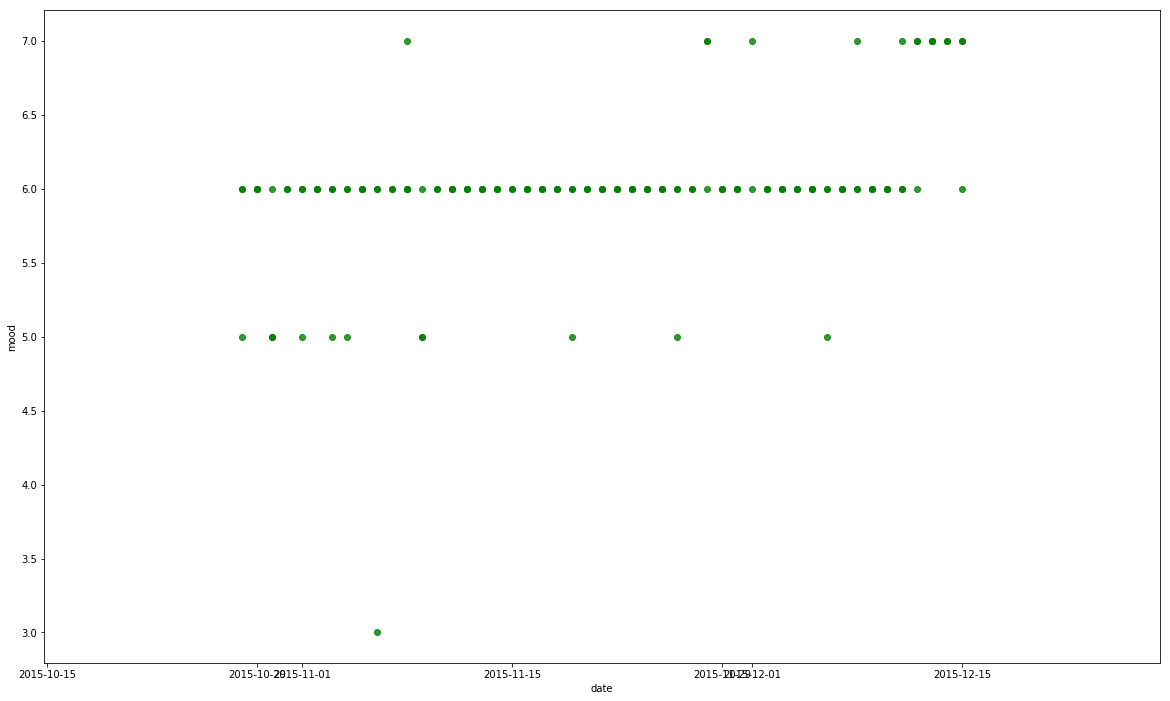

In [222]:
color_map = {
    'control': 'green',
    'depressed': 'blue',
    'anxious': 'orange',
    'depressed_anxious': 'red'
}

pid = pids[3]
data = emm_df.loc[emm_df['pid'] == pid]
#data.groupby('date').plot(x="hour", y="z_mood")
group = data['group'].iloc[0]
sns.regplot(x="date", y="mood", data=data, color=color_map[group], lowess=True)

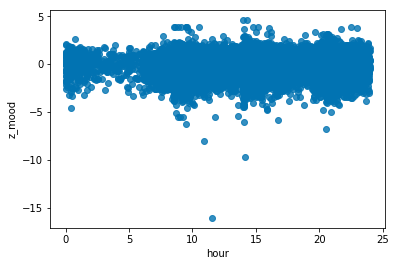

In [147]:
sns.regplot(x="hour", y="z_mood", data=emm_df, lowess=True)

In [129]:
pooled_data = data.set_index(['pid','emm_idx'])

In [144]:
model = PooledOLS.from_formula('mood ~ hour', pooled_data)
results = model.fit(cov_type='unadjusted')
results

Dep. Variable:,mood,R-squared:,0.8675
Estimator:,PooledOLS,R-squared (Between):,0.9948
No. Observations:,160,R-squared (Within):,-1.1359
Date:,"Sun, Jun 16 2019",R-squared (Overall):,0.8675
Time:,20:25:52,Log-likelihood,-323.08
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1041.4
Entities:,1,P-value,0.0000
Avg Obs:,160.00,Distribution:,"F(1,159)"
Min Obs:,160.00,,
Max Obs:,160.00,F-statistic (robust):,1041.4


#### Correlations with within day EMA differences

In [150]:

# builds a dict of lists for the dates with complete EMA responses (all 3)

complete_dates = emm_df.groupby(['pid', 'date'], as_index=False)['emm_idx'].sum()
complete_dates = complete_dates.loc[complete_dates['emm_idx'] == 3]
complete_dates.head()
complete_date_dict = {k: list(v) for k,v in complete_dates.groupby('pid')['date']}

def check_date(row):
    """df.apply function to check for rows that are part of a complete day.
    """
    if  row['pid'] in complete_date_dict:
        return row['date'] in complete_date_dict[row['pid']]
    else:
        return False


complete_date_emm = emm_df[emm_df.apply(check_date, axis=1)]

In [705]:
complete_date_emm_day = complete_date_emm.groupby(['pid', 'emm_idx'], as_index=False).mean()

In [230]:
# pivot_emm = complete_date_emm.pivot_table(index=['pid', 'date'], columns='emm_idx'), doesn't aggregate within participant
pivot_emm = complete_date_emm_day.pivot_table(index=['pid'], columns='emm_idx')

In [241]:
print("Energy z-scores by EMA")
display(pivot_emm['z_energy'].describe())

Energy z-scores by EMA


emm_idx,0,1,2
count,206.000000,206.000000,206.000000
mean,-0.008935,0.170677,-0.128528
std,0.309320,0.215564,0.327979
min,-0.848057,-0.848057,-1.120431
25%,-0.207551,0.058689,-0.338775
50%,0.007862,0.166160,-0.093516
75%,0.178552,0.300036,0.067305
max,1.118194,0.804886,1.122683


In [242]:
print("Mood z-scores by EMA")
display(pivot_emm['z_mood'].describe())

Mood z-scores by EMA


emm_idx,0,1,2
count,206.000000,206.000000,206.000000
mean,-0.059251,0.052778,0.062951
std,0.226411,0.186387,0.227244
min,-0.755665,-0.504760,-0.757597
25%,-0.206280,-0.055382,-0.062607
50%,-0.051812,0.053823,0.069542
75%,0.067496,0.163424,0.198205
max,0.804131,0.772383,1.130130


In [243]:
print("Focus z-scores by EMA")
display(pivot_emm['z_focus'].describe())

Focus z-scores by EMA


emm_idx,0,1,2
count,205.000000,205.000000,205.000000
mean,-0.007093,0.095216,-0.069720
std,0.277406,0.221458,0.268893
min,-1.861985,-0.930155,-1.131355
25%,-0.157372,-0.029898,-0.204606
50%,0.011755,0.094425,-0.057507
75%,0.149508,0.232283,0.089383
max,0.807675,0.817375,1.092409


In [244]:
print("Stress z-scores by EMA")
display(pivot_emm['z_stress'].describe())

Stress z-scores by EMA


emm_idx,0,1,2
count,205.000000,205.000000,205.000000
mean,-0.021537,0.010900,0.031097
std,0.224078,0.204997,0.249845
min,-1.294992,-1.101128,-1.101128
25%,-0.156462,-0.068179,-0.089649
50%,-0.016257,0.017421,0.044629
75%,0.090121,0.114700,0.169001
max,0.721132,0.591872,1.330799


In [248]:
pivot_emm_center = pivot_emm.copy()
pivot_emm_center['z_mood']  = pivot_emm_center['z_mood'] - pivot_emm_center['z_mood'].mean()
pivot_emm_center['z_energy']  = pivot_emm_center['z_energy'] - pivot_emm_center['z_energy'].mean()
pivot_emm_center['z_stress']  = pivot_emm_center['z_stress'] - pivot_emm_center['z_stress'].mean()
pivot_emm_center['z_focus']  = pivot_emm_center['z_focus'] - pivot_emm_center['z_focus'].mean()

In [256]:
diff_df = pd.DataFrame()

#columns = ['mood', 'stress', 'focus', 'energy']
columns = ['z_mood', 'z_stress', 'z_focus', 'z_energy']
for col in columns:
    diff_df["1_0_{}".format(col)] = pivot_emm_center[col][1] - pivot_emm_center[col][0]
    diff_df["2_1_{}".format(col)] = pivot_emm_center[col][2] - pivot_emm_center[col][1]
    diff_df["2_0_{}".format(col)] = pivot_emm_center[col][2] - pivot_emm_center[col][0]
#     diff_df["1_0_{}".format(col)] = pivot_emm[col][1] - pivot_emm[col][0]
#     diff_df["2_1_{}".format(col)] = pivot_emm[col][2] - pivot_emm[col][1]
#     diff_df["2_0_{}".format(col)] = pivot_emm[col][2] - pivot_emm[col][0]
    
    
diff_df = diff_df.groupby('pid').mean()
diff_df = diff_df.reset_index()
diff_df = diff_df.merge(screener_df, on='pid', how='left')

diff_corr_df = diff_df.copy()
diff_corr_df = diff_corr_df.drop('group', axis='columns')
diff_corr_df = diff_corr_df.set_index('pid')
corrs, _, p_vals = run_r_corr(diff_corr_df)

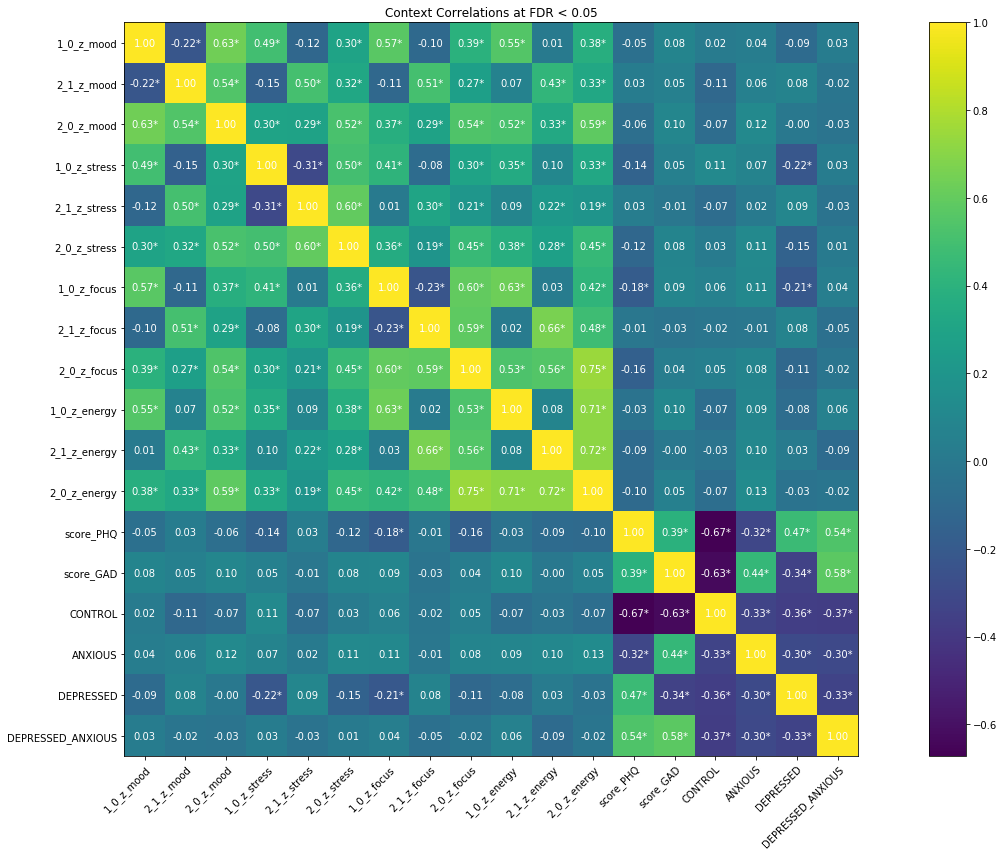

In [257]:
plt = build_corr_mat(corrs, p_vals, diff_corr_df.columns.values, 'Context Correlations at FDR < 0.05', 0.05)
plt.tight_layout()

- depressed individuals have significantly worse stress and focus EMA responses in their second survey of the day compared to their first survey

In [287]:
complete_date_emm_day = complete_date_emm.groupby(['pid', 'emm_idx'], as_index=False).mean()
complete_date_emm_day = complete_date_emm_day.merge(screener_df[['pid', 'group']], on='pid', how='left')
complete_date_emm_day['hour'] = complete_date_emm_day['hour'].round(0)

sns.lineplot(x="emm_idx", y="mood", hue="group", units='pid', estimator=None, data=complete_date_emm_day)

#### Time series exploration

In [702]:
test = emm_df.copy()
test = test.groupby(['pid', 'date']).mean()
test = test.reset_index()

In [712]:
ts_emm = emm_df.drop(screener_df.columns[1:], axis='columns')
ts_emm = ts_emm.loc[(ts_emm['date'] >= '2015-10-27') & (ts_emm['date'] <= '2015-12-31')]
ts_emm = ts_emm.groupby(['pid', 'date'], as_index=False).tail(3)
ts_emm['emm_idx'] = ts_emm.groupby(['pid', 'date'], as_index=False).cumcount()

ts_emm = ts_emm.pivot_table(index='pid', columns=['date', 'emm_idx'])

In [713]:
# TODO handle imputation better
#ts_emm = ts_emm.fillna(0)
ts_emm = ts_emm.reset_index()
ts_emm = ts_emm.drop('pid', axis='columns')

In [789]:
ts_emm.head()

energy                                                            \
date    2015-10-27 2015-10-28           2015-10-29           2015-10-30        
emm_idx          0          0    1    2          0    1    2          0    1   
0              NaN        NaN  NaN  NaN        NaN  NaN  NaN        NaN  NaN   
1              NaN        NaN  NaN  NaN        NaN  NaN  NaN        NaN  NaN   
2              NaN        NaN  NaN  NaN        NaN  NaN  NaN        NaN  NaN   
3              NaN        5.0  5.0  4.0        5.0  4.0  3.0        4.0  4.0   
4              NaN        NaN  NaN  NaN        NaN  NaN  NaN        NaN  NaN   

              ...   z_stress                                            \
date          ... 2015-12-28 2015-12-29                     2015-12-30   
emm_idx    2  ...          2          0         1         2          0   
0        NaN  ...  -0.428902  -0.428902 -0.428902 -0.428902  -0.428902   
1        NaN  ...   0.848946   0.287968  0.287968  0.848946  -1.394964   
2        NaN  ...        NaN   0.103270       NaN       NaN   0.710977   
3        5.0  ...        NaN        NaN       NaN       NaN        NaN   
4        NaN  ...        NaN   1.287862  1.287862 -0.609379  -0.609379   

                                                            
date                        2015-12-31                      
emm_idx         1         2          0         1         2  
0       -0.428902 -0.428902        NaN       NaN       NaN  
1        0.287968  0.287968   0.848946  0.848946  0.848946  
2             NaN       NaN        NaN       NaN       NaN  
3             NaN       NaN        NaN       NaN       NaN  
4        0.339242 -0.609379        NaN       NaN       NaN  

[5 rows x 1960 columns]

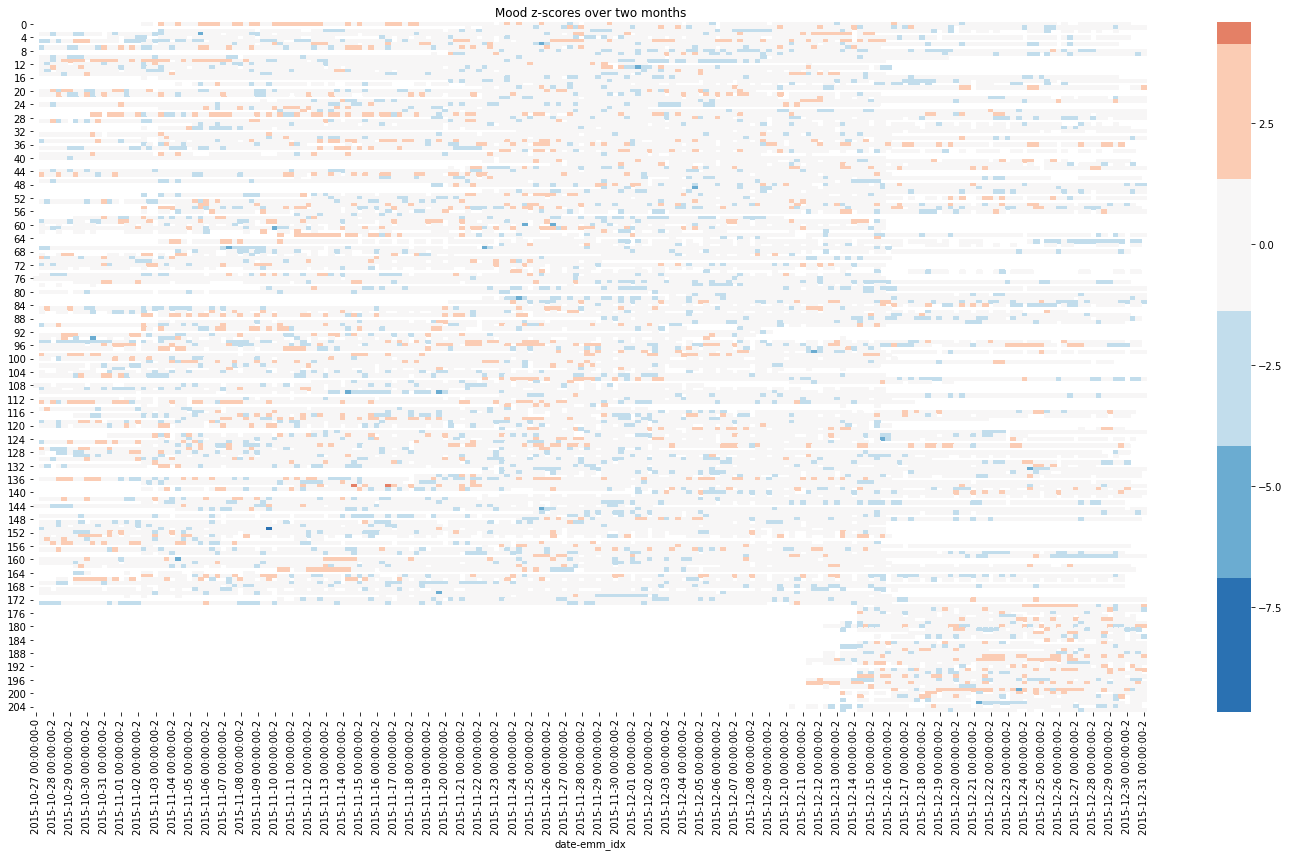

In [757]:
cmap = sns.color_palette("RdBu_r", 7)
sns.heatmap(ts_emm['z_mood'], center=0, cmap=cmap)
plt.title("Mood z-scores over two months")
plt.tight_layout()
plt.savefig('figures/mood_2mo.png', dpi=300)

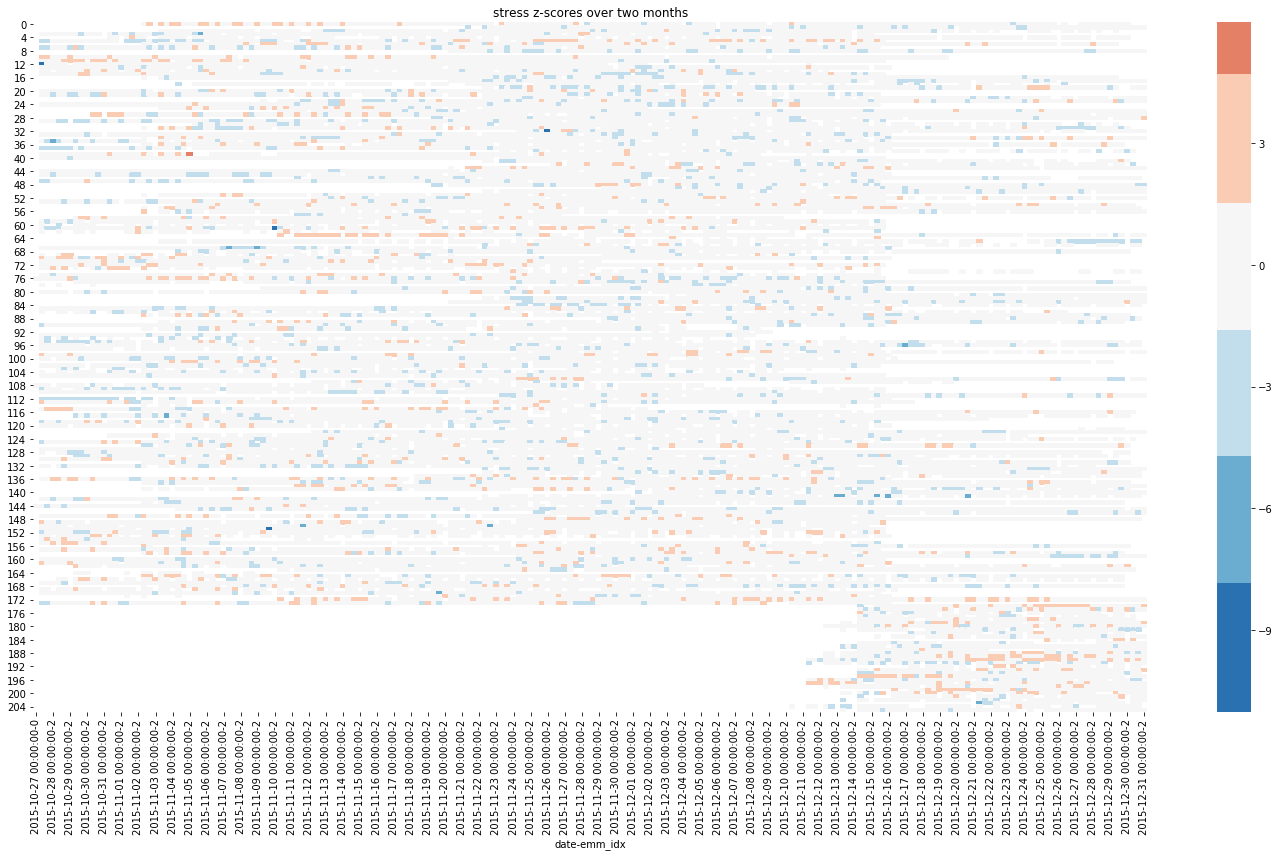

In [758]:
cmap = sns.color_palette("RdBu_r", 7)
sns.heatmap(ts_emm['z_stress'], center=0, cmap=cmap)
plt.title("stress z-scores over two months")
plt.tight_layout()
plt.savefig('figures/stress_2mo.png', dpi=300)

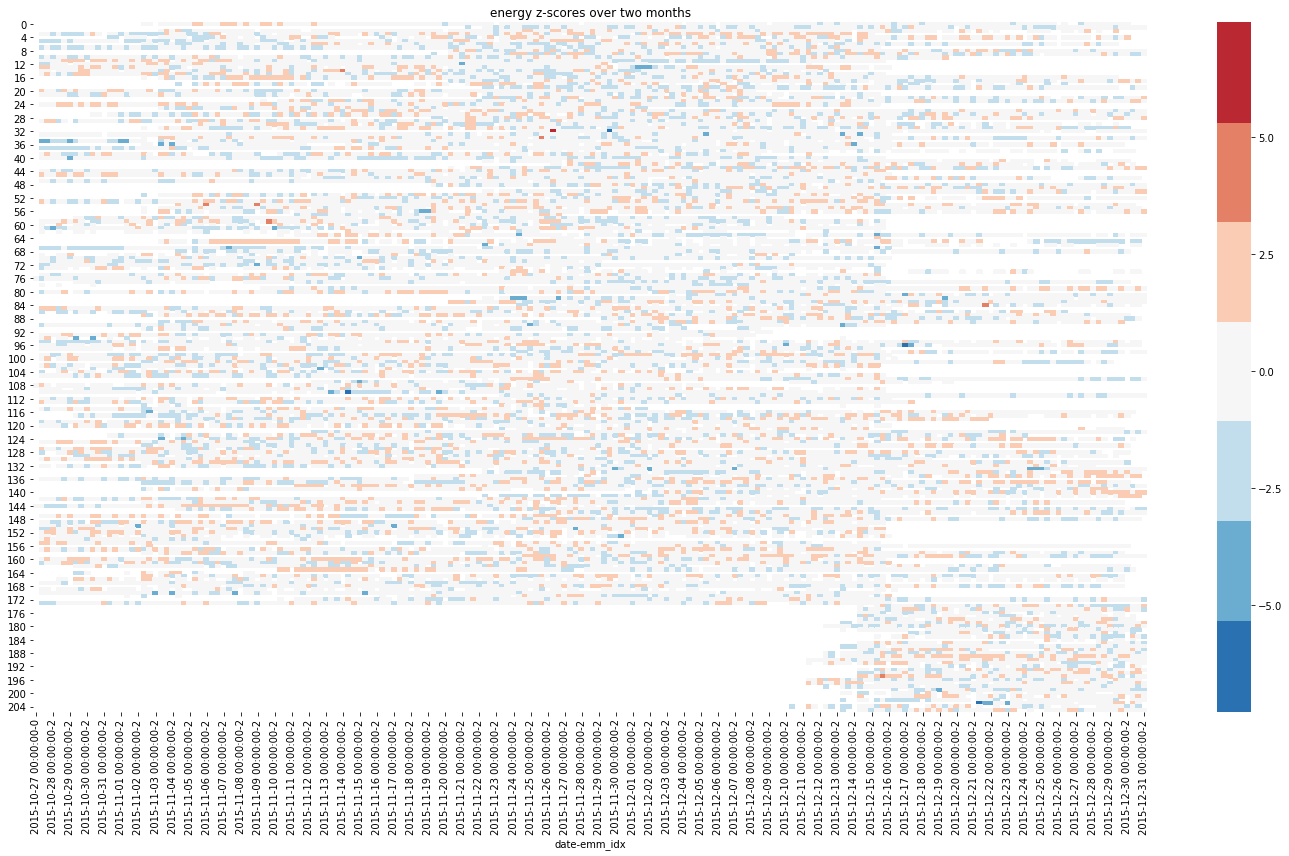

In [759]:
cmap = sns.color_palette("RdBu_r", 7)
sns.heatmap(ts_emm['z_energy'], center=0, cmap=cmap)
plt.title("energy z-scores over two months")
plt.tight_layout()
plt.savefig('figures/energy_2mo.png', dpi=300)

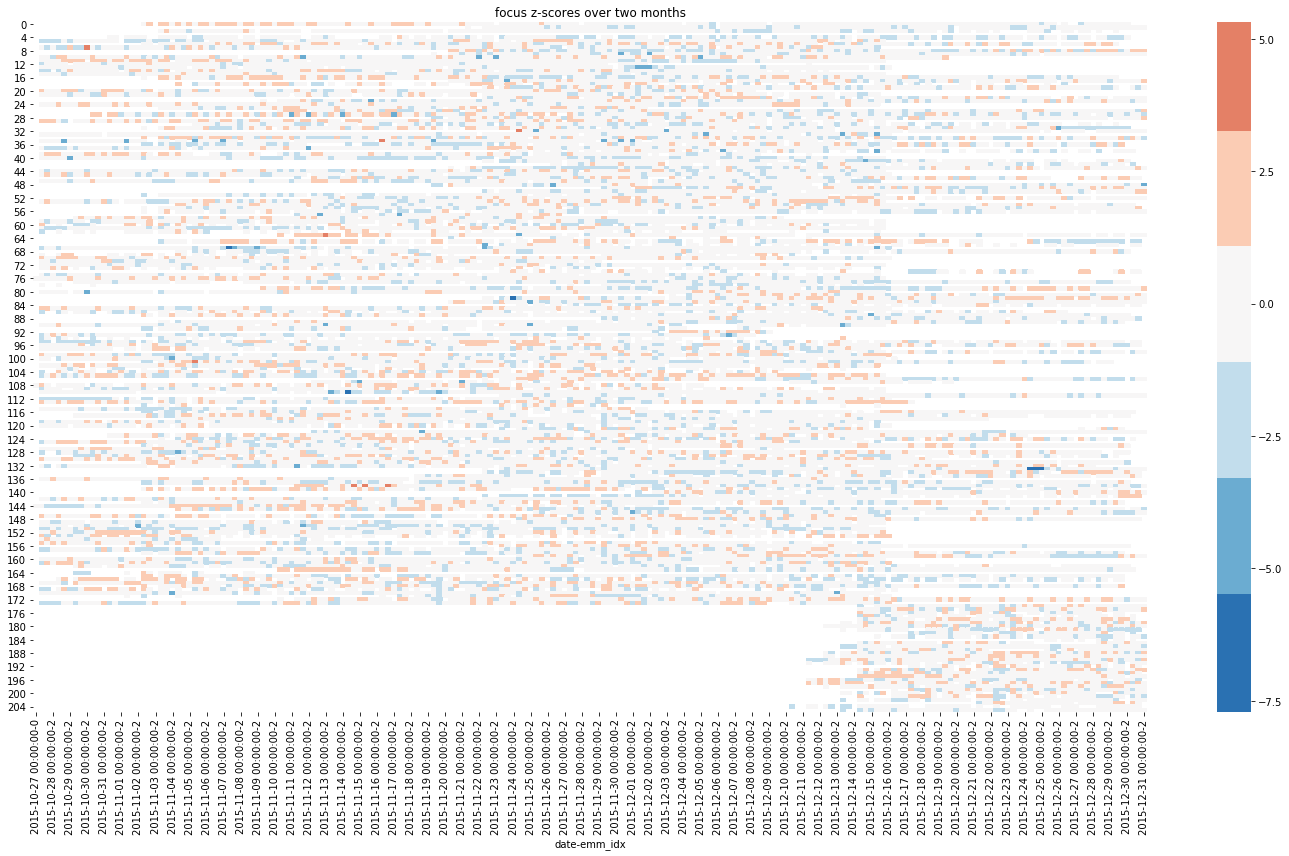

In [760]:
cmap = sns.color_palette("RdBu_r", 7)
sns.heatmap(ts_emm['z_focus'], center=0, cmap=cmap)
plt.title("focus z-scores over two months")
plt.tight_layout()
plt.savefig('figures/focus_2mo.png', dpi=300)

#### Clustering and anomaly detection

In [776]:
cluster_emm = emm_df.drop(screener_df.columns[1:], axis='columns')
cluster_emm = cluster_emm.groupby(['pid', 'date'], as_index=False).tail(3)
cluster_emm['emm_idx'] = cluster_emm.groupby(['pid', 'date'], as_index=False).cumcount()
cluster_emm = cluster_emm.pivot_table(index=['pid', 'date'], columns='emm_idx')
cluster_emm = cluster_emm.reset_index()


In [777]:
#cluster_emm = cluster_emm.loc[cluster_emm['pid'] == '1002060']
drop_cols = ['timestamp', 'mood', 'stress', 'energy', 'focus']
cluster_emm = cluster_emm.drop(drop_cols, axis='columns')
#cluster_emm.columns = cluster_emm.columns.map(lambda x: '_'.join([str(i) for i in x]))

#cluster_emm = cluster_emm.drop(['pid', 'date'], axis='columns')

In [778]:
# merge additional data
fus = pickle.load(open("pkl/fus.df", "rb"))
act = pickle.load(open("pkl/act.df", "rb"))

fus['norm_entropy'] = fus['entropy'] / fus['cluster']
act = act.drop(["UNKNOWN", "ACT_TOTALS"], axis='columns')

cluster_emm = cluster_emm.merge(act, on=['pid', 'date'], how='left')
cluster_emm = cluster_emm.merge(fus, on=['pid', 'date'], how='left')
cluster_emm['is_weekend'] = cluster_emm['date'].dt.weekday >=5
cluster_emm['is_weekend']= cluster_emm['is_weekend'].astype(int)

cluster_emm = cluster_emm[cluster_emm.columns[4:]]
cluster_emm = cluster_emm.fillna(0)

weekend = cluster_emm.pop('is_weekend')
weekend_map = {
    1: 'blue',
    0: 'red'
}
row_colors = weekend.map(weekend_map)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


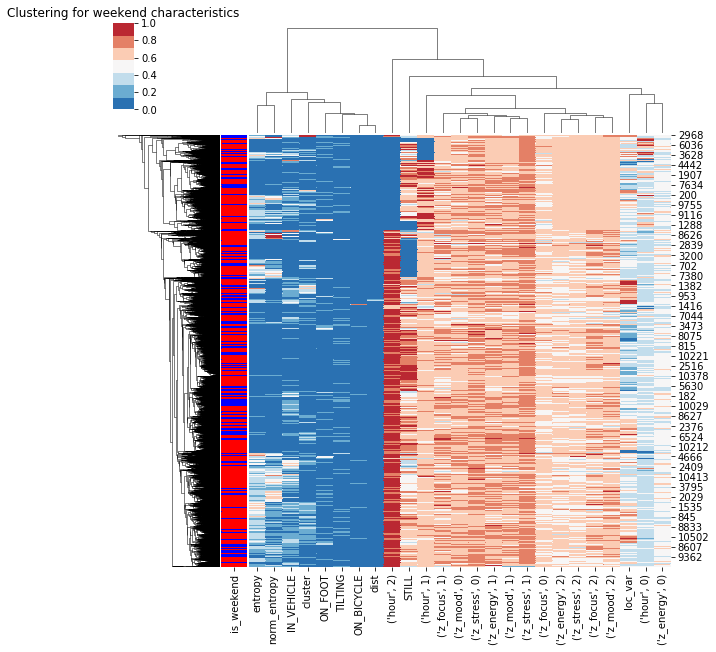

In [783]:
cmap =  sns.color_palette("RdBu_r", 7)
sns.clustermap(cluster_emm, row_colors=row_colors, standard_scale=1, cmap=cmap)
plt.title("Clustering for weekend characteristics")
plt.savefig("figures/weekend_days.png", dpi=300)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


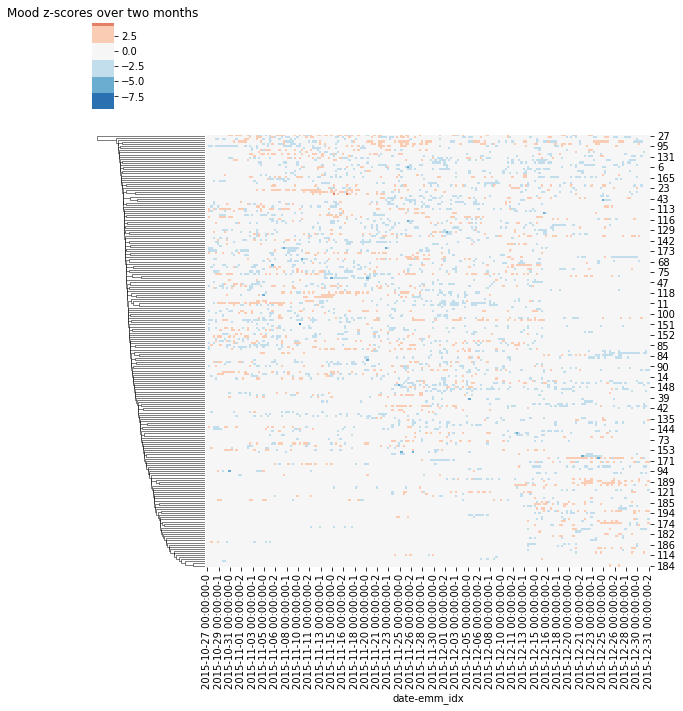

In [788]:
test = ts_emm['z_mood'].fillna(0)

cmap = sns.color_palette("RdBu_r", 7)
sns.clustermap(test, center=0, col_cluster=False, cmap=cmap)
plt.title("Mood z-scores over two months")
plt.tight_layout()

#### Outlier detection

In [687]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [766]:
cluster_emm = emm_df.drop(screener_df.columns[1:], axis='columns')
cluster_emm = cluster_emm.groupby(['pid', 'date'], as_index=False).tail(3)
cluster_emm['emm_idx'] = cluster_emm.groupby(['pid', 'date'], as_index=False).cumcount()
cluster_emm = cluster_emm.pivot_table(index=['pid', 'date'], columns='emm_idx')
cluster_emm = cluster_emm.reset_index()
#cluster_emm = cluster_emm.loc[cluster_emm['pid'] == '1579481']

drop_cols = ['mood', 'stress', 'energy', 'focus', 'pid', 'date', 'timestamp', 'hour']
cluster_emm = cluster_emm.drop(drop_cols, axis='columns')
cluster_emm = cluster_emm.fillna(cluster_emm.mean())

In [767]:
outlier_detector = IsolationForest(random_state=0)
outlier_detector.fit(cluster_emm)
outlier_predictions = outlier_detector.predict(cluster_emm)

row_colors = list(map(lambda x: 'green' if x==1 else 'red', outlier_predictions))
row_colors = pd.Series(row_colors,name='is_outlier')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


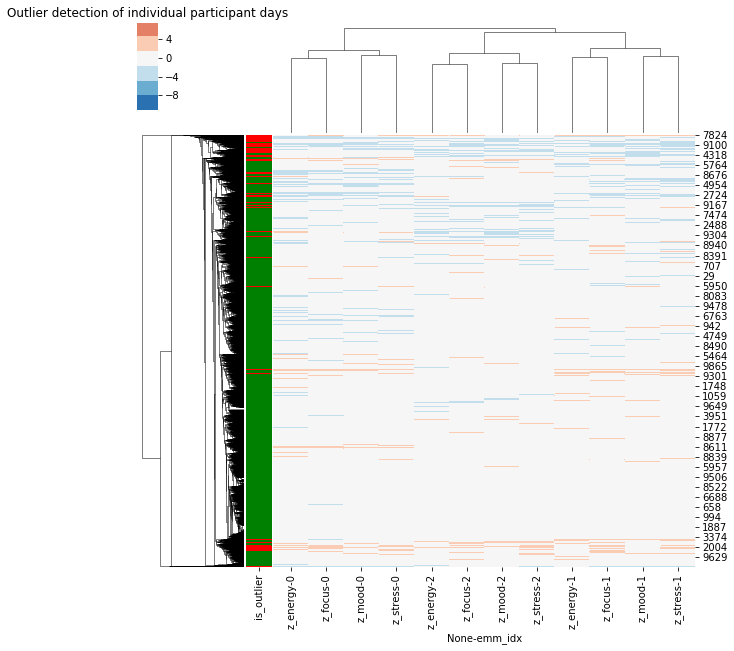

In [768]:
cmap =  sns.color_palette("RdBu_r", 7)
sns.clustermap(cluster_emm, row_colors=row_colors, center=0,cmap=cmap)
plt.title("Outlier detection of individual participant days")
plt.savefig("figures/outlier_days.png", dpi=300)

#### Autocorrelation

In [827]:
def build_autocorr(emm_df, target, n_lags=30):
    """Builds autocorr_dict and df for target EMA.
    
    
    Returns:
        dict, pd.DataFrame: autocorr_dict, autocorr_df
    """
    autocorr_dict = {}
    autocorr_matrix = np.zeros((len(pids), n_lags+1))
    for idx, pid in enumerate(pids):
        emm_pid = emm_df.loc[emm_df['pid'] == pid]
        n_lag = min(n_lags, emm_pid.shape[0])
        autocorr = []
        for i in range(n_lag+1):
            autocorr.append(emm_pid[target].autocorr(lag=i))

        autocorr_dict[pid] = autocorr
        autocorr_matrix[idx] = autocorr + [0] * (n_lags + 1 - len(autocorr))
        
    autocorr_df = pd.DataFrame(autocorr_matrix)
    autocorr_df['pid'] = pids
    autocorr_df = autocorr_df.merge(screener_df[['pid', 'group']], on='pid', how='left')
    autocorr_df = autocorr_df.set_index('pid')
    return autocorr_dict, autocorr_df

color_map = {
    'control': 'green',
    'depressed': 'blue',
    'anxious': 'orange',
    'depressed_anxious': 'red'
}

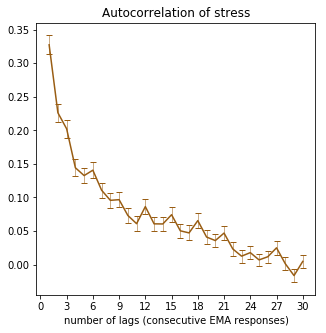

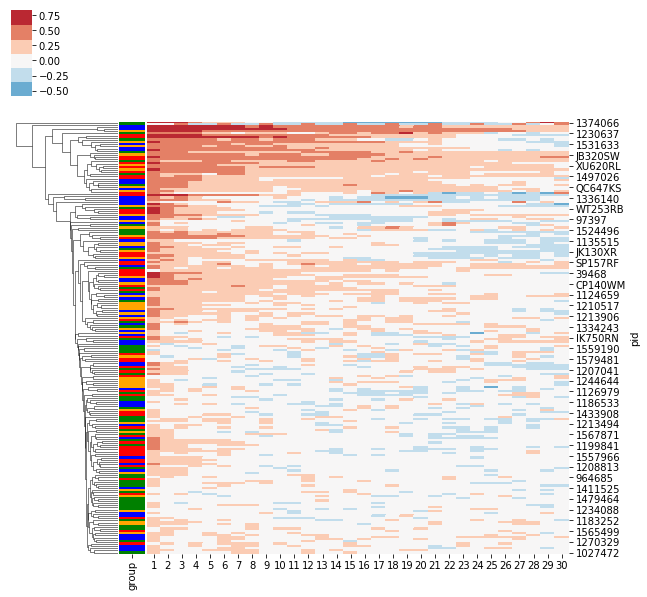

In [852]:
ac_stress_dict, ac_stress_df = build_autocorr(emm_df, 'z_stress')

x = np.arange(1, n_lags+1)
baseline = np.zeros(n_lags)

ac_stress_df = ac_stress_df.dropna()
plt.rcParams["figure.figsize"] = [5,5]
plt.errorbar(x, np.mean(ac_stress_df, axis=0).tolist()[1:], yerr=(np.std(ac_stress_df, axis=0).tolist()[1:]/np.sqrt(ac_stress_df.shape[0])), elinewidth=0.5, capsize=3)
plt.xticks(np.arange(0, n_lags+1, 3))
plt.title("Autocorrelation of stress")
plt.xlabel("number of lags (consecutive EMA responses)")
plt.show()

_ = ac_stress_df.pop(0)
cmap =  sns.color_palette("RdBu_r", 7)
group = ac_stress_df.pop('group')
row_colors = group.map(color_map)
sns.clustermap(ac_stress_df, col_cluster=False, cmap=cmap, center=0, row_colors=row_colors)
plt.show()

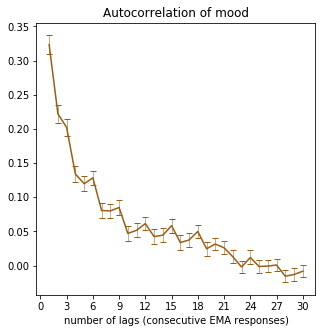

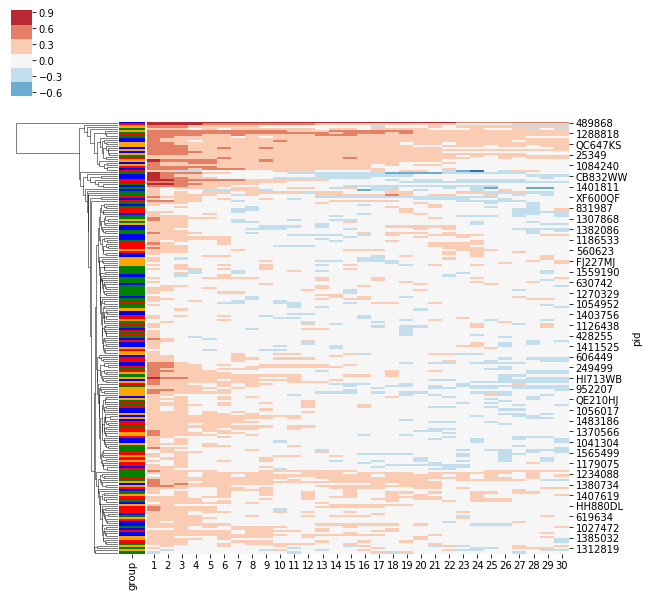

In [849]:
ac_mood_dict, ac_mood_df = build_autocorr(emm_df, 'z_mood')

x = np.arange(1, n_lags+1)
baseline = np.zeros(n_lags)

ac_mood_df = ac_mood_df.dropna()
plt.rcParams["figure.figsize"] = [5,5]
plt.errorbar(x, np.mean(ac_mood_df, axis=0).tolist()[1:], yerr=(np.std(ac_mood_df, axis=0).tolist()[1:]/np.sqrt(ac_mood_df.shape[0])), elinewidth=0.5, capsize=3)
plt.xticks(np.arange(0, n_lags+1, 3))
plt.title("Autocorrelation of mood")
plt.xlabel("number of lags (consecutive EMA responses)")
plt.show()

_ = ac_mood_df.pop(0)
cmap =  sns.color_palette("RdBu_r", 7)
group = ac_mood_df.pop('group')
row_colors = group.map(color_map)
sns.clustermap(ac_mood_df, col_cluster=False, cmap=cmap, center=0, row_colors=row_colors)
plt.show()

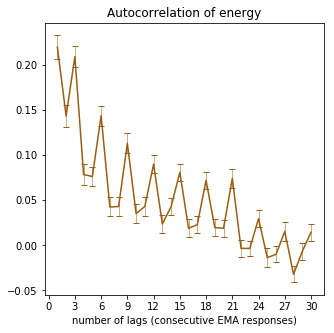

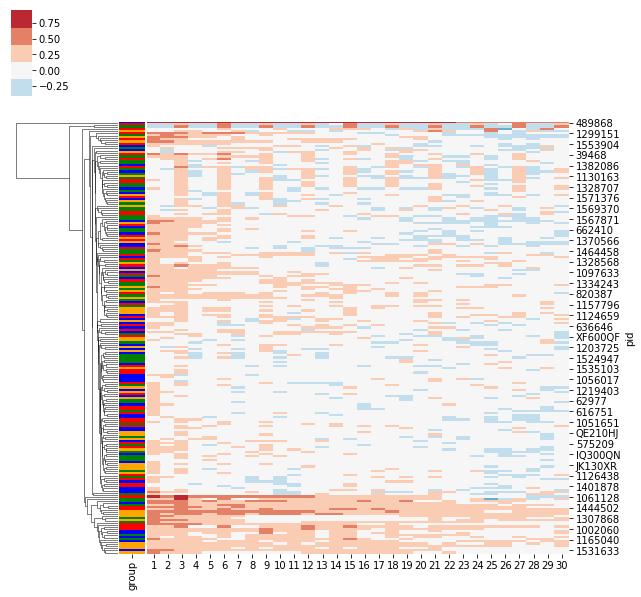

In [850]:
ac_energy_dict, ac_energy_df = build_autocorr(emm_df, 'z_energy')

x = np.arange(1, n_lags+1)
baseline = np.zeros(n_lags)

ac_energy_df = ac_energy_df.dropna()
plt.rcParams["figure.figsize"] = [5,5]
plt.errorbar(x, np.mean(ac_energy_df, axis=0).tolist()[1:], yerr=(np.std(ac_energy_df, axis=0).tolist()[1:]/np.sqrt(ac_energy_df.shape[0])), elinewidth=0.5, capsize=3)
plt.xticks(np.arange(0, n_lags+1, 3))
plt.title("Autocorrelation of energy")
plt.xlabel("number of lags (consecutive EMA responses)")
plt.show()

_ = ac_energy_df.pop(0)
cmap =  sns.color_palette("RdBu_r", 7)
group = ac_energy_df.pop('group')
row_colors = group.map(color_map)
sns.clustermap(ac_energy_df, col_cluster=False, cmap=cmap, center=0, row_colors=row_colors)
plt.show()

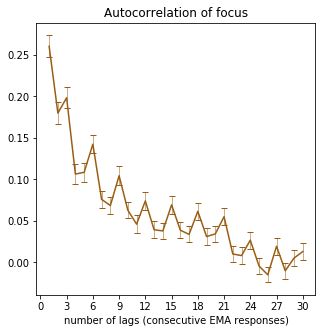

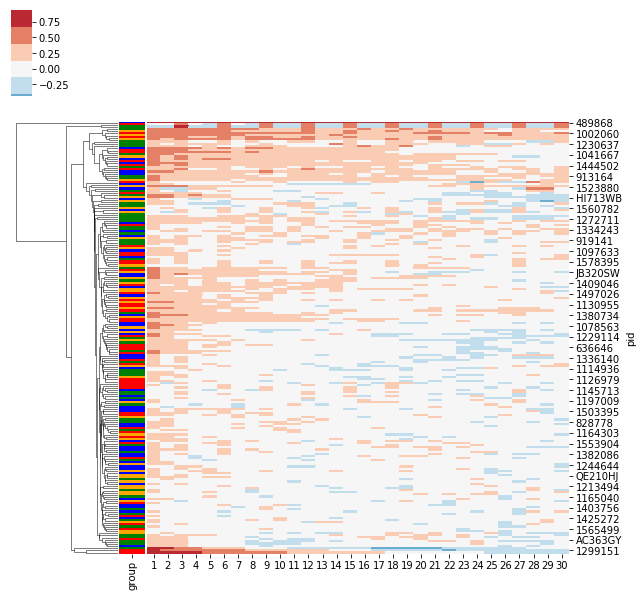

In [851]:
ac_focus_dict, ac_focus_df = build_autocorr(emm_df, 'z_focus')

x = np.arange(1, n_lags+1)
baseline = np.zeros(n_lags)

ac_focus_df = ac_focus_df.dropna()
plt.rcParams["figure.figsize"] = [5,5]
plt.errorbar(x, np.mean(ac_focus_df, axis=0).tolist()[1:], yerr=(np.std(ac_focus_df, axis=0).tolist()[1:]/np.sqrt(ac_focus_df.shape[0])), elinewidth=0.5, capsize=3)
plt.xticks(np.arange(0, n_lags+1, 3))
plt.title("Autocorrelation of focus")
plt.xlabel("number of lags (consecutive EMA responses)")
plt.show()

cmap =  sns.color_palette("RdBu_r", 7)
_ = ac_focus_df.pop(0)
group = ac_focus_df.pop('group')
row_colors = group.map(color_map)
sns.clustermap(ac_focus_df, col_cluster=False, cmap=cmap, center=0, row_colors=row_colors)
plt.show()

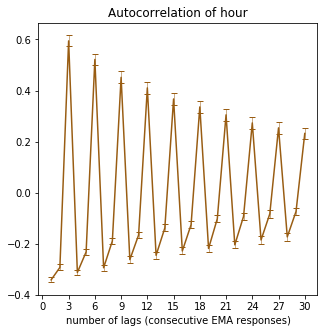

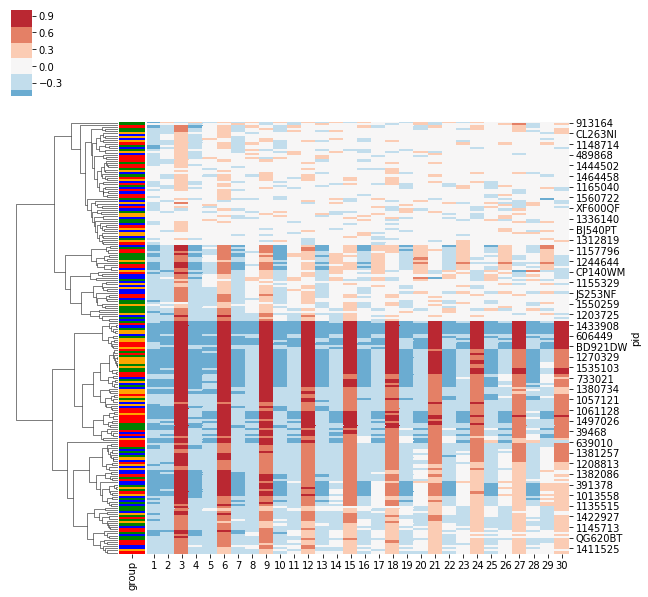

In [844]:
ac_hour_dict, ac_hour_df = build_autocorr(emm_df, 'hour')

x = np.arange(1, n_lags+1)
baseline = np.zeros(n_lags)

ac_hour_df = ac_hour_df.dropna()
plt.rcParams["figure.figsize"] = [5,5]
plt.errorbar(x, np.mean(ac_hour_df, axis=0).tolist()[1:], yerr=(np.std(ac_hour_df, axis=0).tolist()[1:]/np.sqrt(ac_hour_df.shape[0])), elinewidth=0.5, capsize=3)
plt.xticks(np.arange(0, n_lags+1, 3))
plt.title("Autocorrelation of hour")
plt.xlabel("number of lags (consecutive EMA responses)")
plt.show()

cmap =  sns.color_palette("RdBu_r", 7)
_ = ac_hour_df.pop(0)
group = ac_hour_df.pop('group')
row_colors = group.map(color_map)
sns.clustermap(ac_hour_df, col_cluster=False, method='complete', cmap=cmap, center=0, row_colors=row_colors)
plt.show()

### Other sensor modalities

In [294]:
# load processed daily data
emm = pickle.load(open('data/emm.df', 'rb'))
scr = pickle.load(open('data/scr.df', 'rb'))
tch = pickle.load(open('data/tch.df', 'rb'))
ems = pickle.load(open('data/ems.df', 'rb'))
coe = pickle.load(open('data/coe_new.df', 'rb'))
app = pickle.load(open('data/app.df', 'rb'))
run_fb = pickle.load(open('data/run_fb.df', 'rb'))
run_email = pickle.load(open('data/run_email.df', 'rb'))
act = pickle.load(open('data/act_test.df', 'rb'))

emm_cols = ['mood', 'stress', 'energy', 'focus']
ems_cols = ['sleep_amount', 'sleep_quality']
coe_cols = ['call_in_count', 'call_out_count', 'sms_in_count', 'sms_out_count']
act_cols = ['IN_VEHICLE', 'ON_BICYCLE', 'ON_FOOT', 'STILL', 'TILTING', 'UNKNOWN']
fus_cols = ['entropy', 'norm_entropy', 'cluster', 'loc_var']

ems_raw =  process_csv_all_daily('ems', normalize=False)
ems_raw['sleep_amount'] = ems_raw['sleep_amount'] / (1000*60*60)
ems_raw['sleep_quality'] = ems_raw['sleep_quality'].astype(int)

emm_raw =  process_csv_all_daily('emm', normalize=False)

fus = pickle.load(open('pkl/fus.df', 'rb'))
fus['norm_entropy'] = fus['entropy'] / fus['cluster']

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [296]:
pids = id_dirs.copy()
pids.remove('1496251') # missing timezone data

In [297]:
emm_day_df = emm_df.copy()

# exclude days that were part of a missing day rollover
keep_dates = emm_df.groupby(['pid', 'date'], as_index=False)['emm_idx'].sum()
keep_dates = keep_dates.loc[keep_dates['emm_idx'] <= 3]
keep_dates.head()
keep_date_dict = {k: list(v) for k,v in keep_dates.groupby('pid')['date']}

def check_date(row):
    """df.apply function to check for rows that are part of a keep day.
    """
    if  row['pid'] in keep_date_dict:
        return row['date'] in keep_date_dict[row['pid']]
    else:
        return False


emm_day_df = emm_day_df[emm_day_df.apply(check_date, axis=1)]
emm_day_df = emm_day_df.groupby(['pid', 'date'], as_index=False).mean()
emm_day_df = emm_day_df.drop(['timestamp', 'hour'], axis='columns')

In [298]:
emm_day_df['missing_ema'] = (emm_day_df['emm_idx'] < 1).astype(int)
emm_day_df = emm_day_df.drop(['emm_idx'], axis='columns')

In [299]:
fus = pickle.load(open("pkl/fus.df", "rb"))
act = pickle.load(open("pkl/act.df", "rb"))

fus['norm_entropy'] = fus['entropy'] / fus['cluster']
act = act.drop(["UNKNOWN", "ACT_TOTALS"], axis='columns')

In [301]:
emm_day_df = emm_day_df.merge(act, on=['pid', 'date'], how='left')
emm_day_df = emm_day_df.merge(fus, on=['pid', 'date'], how='left')

In [343]:
emm_day_cluster = emm_day_df.copy()
drop_cols = ['pid', 'score_PHQ', 'score_GAD', 'CONTROL', 'ANXIOUS', 'DEPRESSED', 'DEPRESSED_ANXIOUS']
emm_day_cluster = emm_day_cluster.groupby("pid", as_index=False).mean()
emm_day_cluster = emm_day_cluster.merge(screener_df[['pid', 'group']], on='pid', how='left')
group = emm_day_cluster.pop("group")
emm_day_cluster = emm_day_cluster.drop(drop_cols, axis='columns')
emm_day_cluster = emm_day_cluster.fillna(0)

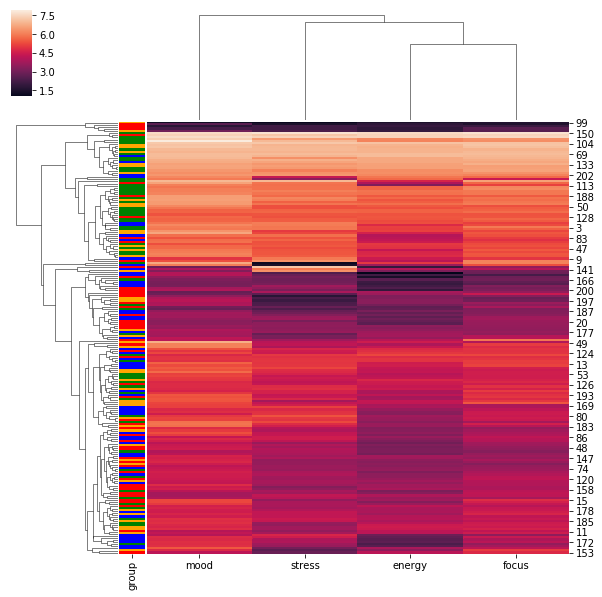

In [357]:
color_map = {
    'control': 'green',
    'depressed': 'blue',
    'anxious': 'orange',
    'depressed_anxious': 'red'
}

row_colors = group.map(color_map)
include_cols = ['mood', 'energy', 'stress', 'focus']
sns.clustermap(emm_day_cluster[include_cols], row_colors=row_colors)

## Remarks

- significant correlations between missing EMA surveys and variability in EMA response time
- mood is worst at the first EMA response
- energy and focus is the highest at the second EMA response